In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import scipy.interpolate
import itertools
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

In [8]:
import pandas_datareader.data as pdr
import yfinance as yf

import datetime
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [10]:
from numba import cuda

In [11]:
start_date = '2008-08-01'
end_date = '2016-04-29'

In [12]:
data = pd.ExcelFile('./data/VIX_VS.xlsx')
dfs = {sheet_name: data.parse(sheet_name, header=0) for sheet_name in data.sheet_names}

futures_data = pd.ExcelFile('./data/VIX_F.xlsx')
fdf = {sheet_name: futures_data.parse(sheet_name, header=0) for sheet_name in futures_data.sheet_names}
futures = fdf['TRUNC']
futures = futures.sort_values(by='Date')
futures = futures.set_index('Date')
futures['F1_shift'] = futures['F1'].shift(-1)
futures = futures.truncate(start_date, end_date)
futures = futures.fillna(0)

In [13]:
yf.pdr_override()

start = datetime.datetime(2007, 1, 1)
end = datetime.datetime(2017, 1, 1)

# raw adjusted close prices
VIX = pdr.get_data_yahoo('^VIX', start, end)
VVIX = pdr.get_data_yahoo('^VVIX', start, end)
VIX.reset_index(level=0, inplace=True)
VVIX.reset_index(level=0, inplace=True)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [14]:
VIX['VIX_14_EMA'] = VIX['Adj Close'].ewm(span=14, adjust=False).mean()
VIX['VIX_50_EMA'] = VIX['Adj Close'].ewm(span=50, adjust=False).mean()
VIX['VIX_100_EMA'] = VIX['Adj Close'].ewm(span=100, adjust=False).mean()

VIX['14_MA_SIG'] = np.where(VIX['Adj Close']>VIX['VIX_14_EMA'],1.0,0.0)
VIX['14_MA_SIG'] = VIX['14_MA_SIG'].diff()
VIX['50_MA_SIG'] = np.where(VIX['Adj Close']>VIX['VIX_50_EMA'],1.0,0.0)
VIX['50_MA_SIG'] = VIX['50_MA_SIG'].diff()
VIX['100_MA_SIG'] = np.where(VIX['Adj Close']>VIX['VIX_100_EMA'],1.0,0.0)
VIX['100_MA_SIG'] = VIX['100_MA_SIG'].diff()

In [15]:
VVIX['HL_sprd'] = (VVIX['High'] - VVIX['Low'])/VVIX['Low']

In [16]:
VIX = VIX.set_index('Date')
VIX = VIX.truncate(start_date, end_date)
VIX = VIX[['Adj Close', '14_MA_SIG', '50_MA_SIG', '100_MA_SIG']]
VVIX = VVIX.set_index('Date')
VVIX = VVIX.truncate(start_date, end_date)
VVIX = VVIX[['Adj Close', 'HL_sprd']]

In [17]:
def implied_info(date, year, expiration=30, callput='C', vix=VIX, data=dfs):
    
    test = data[year][dfs[year]['Date']==date][dfs[year]['CallPut']==callput][dfs[year]['Days']==expiration]
    asset = float(vix[vix['Date']==date]['Adj Close'])

    percent = np.arange(0.8, 1.55, 0.05)
    price_list = {f'{round(per*100, 0)}%': round(asset * per, 5) for per in percent}

    # test = test.set_index(test.pop('ImpliedStrike'))
    imst = np.array(test['ImpliedStrike'])
    imvo = np.array(test['ImpliedVolatility'])

    for prc in price_list.values():
        if prc not in imst:
            s = pd.Series({'Date': date, 'Days': expiration, 'Delta': np.nan, 'CallPut': callput, 'ImpliedVolatility': np.nan, 'ImpliedStrike': prc, 'ImpliedPremium': np.nan, 'Dispersion': np.nan})
            test = test.append(s, ignore_index=True)
    test = test.sort_values(by='ImpliedStrike')

    func = scipy.interpolate.interp1d(imst, imvo, fill_value='extrapolate')
    test["ImpliedVolatility"] = func(test['ImpliedStrike'])
    test = test.bfill().ffill()
    #test = test.drop('index')
    # plt.scatter(x=test['ImpliedStrike'], y=test['ImpliedVolatility'])
    
    return test, price_list

In [18]:
with open('./data/opt_features.pickle', 'rb') as file:
    opt_features = pickle.load(file)
opt_features = pd.DataFrame(opt_features).transpose()

'''
# 1-month, 2-month, 3-month, 6-month, 9-month, 12-month
maturity = {'1-mth': 30, '2-mth': 60, '3-mth': 91, '6-mth': 182, '9-mth': 273, '12-mth': 365}
sprd = [('120.0%', '80.0%'), ('100.0%', '80.0%'), ('120.0%', '100.0%'), ('150.0%', '100.0%')]
c_p = ('C', 'P')

_dt = list()
for yr in dfs.keys():
    _dt = _dt + list(np.unique(dfs[yr]['Date']))

opt_features = {_date: {} for _date in _dt}
for dt in _dt:
    for mth, mtrty in maturity.items():
        for cp in c_p:
            for spd in sprd:
                
                yr = str(pd.to_datetime(dt).year)
                _implied, _pricels = implied_info(date=dt, year=yr, expiration=mtrty, callput=cp)
                ft = float(_implied[_implied['ImpliedStrike'] == _pricels[spd[0]]]['ImpliedVolatility'])
                pt = float(_implied[_implied['ImpliedStrike'] == _pricels[spd[1]]]['ImpliedVolatility'])
                skew_diff = ft - pt
                opt_features[dt][f'Skew IV Sprd. {cp} {mth} {spd[0]} - {spd[1]}'] = skew_diff
'''

"\n# 1-month, 2-month, 3-month, 6-month, 9-month, 12-month\nmaturity = {'1-mth': 30, '2-mth': 60, '3-mth': 91, '6-mth': 182, '9-mth': 273, '12-mth': 365}\nsprd = [('120.0%', '80.0%'), ('100.0%', '80.0%'), ('120.0%', '100.0%'), ('150.0%', '100.0%')]\nc_p = ('C', 'P')\n\n_dt = list()\nfor yr in dfs.keys():\n    _dt = _dt + list(np.unique(dfs[yr]['Date']))\n\nopt_features = {_date: {} for _date in _dt}\nfor dt in _dt:\n    for mth, mtrty in maturity.items():\n        for cp in c_p:\n            for spd in sprd:\n                \n                yr = str(pd.to_datetime(dt).year)\n                _implied, _pricels = implied_info(date=dt, year=yr, expiration=mtrty, callput=cp)\n                ft = float(_implied[_implied['ImpliedStrike'] == _pricels[spd[0]]]['ImpliedVolatility'])\n                pt = float(_implied[_implied['ImpliedStrike'] == _pricels[spd[1]]]['ImpliedVolatility'])\n                skew_diff = ft - pt\n                opt_features[dt][f'Skew IV Sprd. {cp} {mth} {spd[0]}

### Split Training & Validation Set

In [19]:
split_date = pd.Timestamp('2014-12-31')

In [20]:
comp = pd.concat([opt_features, VIX, VVIX, futures], axis=1, join='inner')

In [21]:
comp

,Skew IV Sprd. C 1-mth 100.0% - 80.0%,Skew IV Sprd. C 1-mth 120.0% - 100.0%,Skew IV Sprd. C 1-mth 120.0% - 80.0%,Skew IV Sprd. C 1-mth 150.0% - 100.0%,Skew IV Sprd. C 12-mth 100.0% - 80.0%,Skew IV Sprd. C 12-mth 120.0% - 100.0%,Skew IV Sprd. C 12-mth 120.0% - 80.0%,Skew IV Sprd. C 12-mth 150.0% - 100.0%,Skew IV Sprd. C 2-mth 100.0% - 80.0%,Skew IV Sprd. C 2-mth 120.0% - 100.0%,...,Cont 6/3,Cont 7/3,Cont 5/4,Cont 6/4,Cont 7/4,Cont 6/5,Cont 7/5,Cont 7/6,F1,F1_shift
2008-08-01,0.053142,0.090457,0.143599,0.213791,0.026639,0.026688,0.053326,0.049460,0.045106,0.044308,...,0.003886,-1.000000,-0.017757,0.006929,-1.000000,0.025132,-1.000000,-1.000000,22.950,22.780
2008-08-04,0.106053,0.086304,0.192357,0.169489,0.036722,0.025759,0.062482,0.050097,0.069439,0.064418,...,-0.011658,-0.005613,-0.015611,-0.007372,-0.001301,0.008370,0.014537,0.006116,22.780,21.440
2008-08-05,0.113092,0.092263,0.205355,0.197080,0.001975,0.031517,0.033492,0.054391,0.057422,0.069350,...,-0.004450,0.004450,-0.018733,-0.002230,0.006690,0.016818,0.025909,0.008941,21.440,20.700
2008-08-06,0.103964,0.103190,0.207154,0.238921,0.014093,0.044872,0.058965,0.064270,0.063864,0.063158,...,0.004496,-1.000000,-0.020107,-0.001787,-1.000000,0.018696,-1.000000,-1.000000,20.700,21.510
2008-08-07,0.107301,0.094518,0.201819,0.208200,0.023910,0.036761,0.060671,0.056689,0.040436,0.069328,...,-0.015693,-0.003923,-0.019231,-0.013112,-0.001311,0.006239,0.018271,0.011957,21.510,20.910
2008-08-08,0.133927,0.101081,0.235008,0.234201,0.012559,0.034171,0.046729,0.057790,0.052210,0.082211,...,-0.004421,0.002653,-0.016747,-0.007492,-0.000441,0.009413,0.016584,0.007105,20.910,20.290
2008-08-11,0.115584,0.135478,0.251061,0.283341,0.006438,0.033513,0.039951,0.059503,0.058331,0.085997,...,-0.002656,0.010624,-0.018543,-0.005298,0.007947,0.013495,0.026991,0.013316,20.290,21.280
2008-08-12,0.140149,0.104543,0.244692,0.233491,0.021413,0.030695,0.052108,0.055202,0.036242,0.074508,...,0.005674,0.017023,-0.018245,0.000869,0.012163,0.019469,0.030973,0.011285,21.280,21.500
2008-08-13,0.093490,0.110993,0.204483,0.234231,0.020606,0.028430,0.049037,0.054072,0.066834,0.076889,...,-0.004729,-0.012468,-0.016781,-0.003873,-0.011618,0.013129,0.005252,-0.007775,21.500,20.800
2008-08-14,0.075166,0.124251,0.199416,0.260478,0.015651,0.038626,0.054277,0.057143,0.041997,0.082961,...,0.007499,0.012351,-0.010141,0.007055,0.011905,0.017372,0.022272,0.004816,20.800,20.180


In [22]:
train = pd.DataFrame(comp[:split_date])
test = pd.DataFrame(comp[split_date:])

# scaler = MinMaxScaler(feature_range=(-1, 1)) # MinMaxScaler : for data Normalization
# train_sc = scaler.fit_transform(train)
# test_sc = scaler.transform(test)

In [23]:
train_sc = pd.DataFrame(comp[:split_date])
test_sc = pd.DataFrame(comp[split_date:])

In [24]:
df_train_sc = pd.DataFrame(train_sc, columns=comp.columns, index=train_sc.index)
df_test_sc = pd.DataFrame(test_sc, columns=comp.columns, index=test_sc.index)

In [25]:
X_train =  df_train_sc.dropna().drop(['F1_shift', 'F1'], axis=1)
y_train = df_train_sc.dropna()['F1_shift']

X_test = df_test_sc.dropna().drop(['F1_shift', 'F1'], axis=1)
y_test = df_test_sc.dropna()['F1_shift']

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (1576, 69, 1)
Test shape:  (335, 69, 1)


### Create Our LSTM Model with 10 Layers & Fit the Model

In [26]:
X_train_lmse.shape[1:]

(69, 1)

In [27]:
LSTM(units=150, activation='tanh', recurrent_activation='hard_sigmoid', input_shape=(X_train_lmse.shape[1:]),
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
     recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
     kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
     recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False,
     go_backwards=False, stateful=False, unroll=False)

In [28]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=150, activation='relu', recurrent_activation='hard_sigmoid', input_shape=(X_train_lmse.shape[1:]),
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, dropout=0.0,
     recurrent_dropout=0.0, implementation=2, return_sequences=True))

lstm_model.add(LSTM(units=150, activation='relu', recurrent_activation='hard_sigmoid', 
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, dropout=0.0,
     recurrent_dropout=0.0, implementation=2, return_sequences=True))


lstm_model.add(LSTM(units=150, activation='relu', recurrent_activation='hard_sigmoid', 
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, dropout=0.0,
     recurrent_dropout=0.0, implementation=2, return_sequences=True))


lstm_model.add(LSTM(units=150, activation='relu', recurrent_activation='hard_sigmoid', 
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, dropout=0.0,
     recurrent_dropout=0.0, implementation=2, return_sequences=True))


lstm_model.add(LSTM(units=150, activation='relu', recurrent_activation='hard_sigmoid', 
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, dropout=0.0,
     recurrent_dropout=0.0, implementation=2, return_sequences=True))


lstm_model.add(LSTM(units=150, activation='relu', recurrent_activation='hard_sigmoid', 
     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
     bias_initializer='zeros', unit_forget_bias=True, dropout=0.0,
     recurrent_dropout=0.0, implementation=2))


lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=300, batch_size=256, 
                                    verbose=1, shuffle=False, callbacks=[])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
1576/1576 [==============================] - 19s 12ms/step - loss: 614.3126
Epoch 2/300
1576/1576 [==============================] - 14s 9ms/step - loss: 230.4408
Epoch 3/300
1576/1576 [==============================] - 13s 9ms/step - loss: 142.1090
Epoch 4/300
1576/1576 [==============================] - 13s 8ms/step - loss: 210.4646
Epoch 5/300
1576/1576 [==============================] - 14s 9ms/step - loss: 176.9051
Epoch 6/300
1576/1576 [==============================] - 14s 9ms/step - loss: 412.0820
Epoch 7/300
1576/1576 [==============================] - 15s 9ms/step - loss: 234.5323
Epoch 8/300
1576/1576 [==============================] - 15s 9ms/step - loss: 301.9317
Epoch 9/300
1576/1576 [==============================] - 14s 9ms/step - loss: 92.0779
Epoch 10/300
1576/1576 [==============================] - 14s 9ms/step - loss: 149.6845
Epoch 11/

1576/1576 [==============================] - 13s 8ms/step - loss: 3.8845
Epoch 182/300
1576/1576 [==============================] - 14s 9ms/step - loss: 3.5913
Epoch 183/300
1576/1576 [==============================] - 15s 9ms/step - loss: 3.6589
Epoch 184/300
1576/1576 [==============================] - 15s 9ms/step - loss: 3.6849
Epoch 185/300
1576/1576 [==============================] - 14s 9ms/step - loss: 3.7593
Epoch 186/300
1576/1576 [==============================] - 14s 9ms/step - loss: 4.1188
Epoch 187/300
1576/1576 [==============================] - 15s 9ms/step - loss: 3.7939
Epoch 188/300
1576/1576 [==============================] - 15s 10ms/step - loss: 3.5980
Epoch 189/300
1576/1576 [==============================] - 16s 10ms/step - loss: 4.0020
Epoch 190/300
1576/1576 [==============================] - 15s 9ms/step - loss: 3.8053
Epoch 191/300
1576/1576 [==============================] - 13s 8ms/step - loss: 4.5919
Epoch 192/300
1576/1576 [==============================

In [29]:
X_test_lmse = np.array(X_test_lmse)
X_test_lmse = np.reshape(X_test_lmse, X_test_lmse.shape)

### Evaluate our Prediction on Test Set

In [30]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
print('-------------------------------------------------------------------------------------------------------')
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('LSTM MSE : %f' %lstm_test_mse)

The R2 score on the Train set is:	0.959
The R2 score on the Test set is:	0.633
-------------------------------------------------------------------------------------------------------
335/335 [==============================] - 24s 72ms/step
LSTM MSE : 4.521706


### Inverse Transform the Normalized Predition to Asset Price

In [55]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#real_world = scaler.inverse_transform(pd.DataFrame(y_test))
#predicted = scaler.inverse_transform(pd.DataFrame(y_pred_test_lstm))

real_world = pd.DataFrame(y_test, index=test.index)
predicted = pd.DataFrame(y_pred_test_lstm, index=test.index)

### Demonstrate Our Result

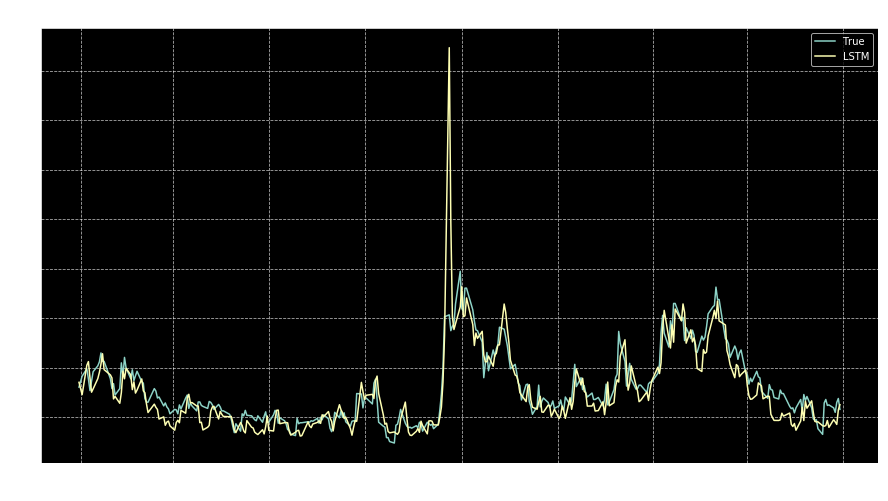

In [64]:
plt.figure(figsize=(15,8))
plt.plot(real_world.index, real_world[0], label='True')
plt.plot(predicted, label='LSTM')

plt.xlabel('Observation')
plt.ylabel('Asset Price Scaled')
plt.legend()
plt.grid(linestyle='--',alpha=0.7)
plt.title('Predicted Results',fontsize=20)
plt.show()

In [36]:
cuda.select_device(0)
cuda.close()